In [3]:
import pandas as pd
import numpy as np
import pickle
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import time
import argparse
import os
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('../baselines/RNN/datasets/Dataset 1.csv') #to be comparable with the size of other datasets, select ~5000 data points from the reference
df['TRIMER_mol'] = df['TRIMER'].apply(Chem.MolFromSmiles)
df = df.dropna()

In [5]:
nbits = 1024
fp = df['TRIMER_mol'].apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=nbits))
df['fps'] = fp

In [6]:
df.columns

Index(['TRIMER', 'Excitation Energy (eV)', 'IP (eV)', 'EA (eV)',
       'Calib. IP (eV)', 'Calib. EA (eV)', 'Calib. Excitation Energy (eV)',
       'TRIMER_mol', 'fps'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

#reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [8]:
from torch.utils.data import Dataset, DataLoader

class TrimerDataset(Dataset):
    def __init__(self, data, target_column):
        self.data = data
        self.target_column = target_column

    def __getitem__(self, index):
        tokens = self.data.loc[index, "fps"]
        target = self.data.loc[index, self.target_column]

        tokens_tensor = torch.tensor(tokens, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return tokens_tensor, target_tensor

    def __len__(self):
        return len(self.data)


In [9]:
target_column = "EA (eV)"
train_dataset = TrimerDataset(train_data, target_column)
test_dataset = TrimerDataset(test_data, target_column)


In [11]:
batch_size = 32
shuffle = True
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)


In [12]:
import torch
from torch import nn
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [13]:
for i in range(5):
    tokens, target = train_dataset[i]
    print(f"Sample {i + 1}:")
    print(f"Tokens: {tokens}")
    print(f"Target: {target}\n")

Sample 1:
Tokens: tensor([1, 0, 0,  ..., 0, 0, 0])
Target: 2.458224058151245

Sample 2:
Tokens: tensor([0, 0, 0,  ..., 0, 0, 0])
Target: 1.7806440591812134

Sample 3:
Tokens: tensor([0, 0, 0,  ..., 0, 0, 0])
Target: 1.791316032409668

Sample 4:
Tokens: tensor([0, 1, 0,  ..., 0, 1, 0])
Target: 1.6426440477371216

Sample 5:
Tokens: tensor([0, 0, 0,  ..., 0, 0, 0])
Target: 2.719320058822632



In [14]:
# from Mohit
class RNN(nn.Module):
    def __init__(self, seq_len, emb_dim, lstm_dim, linear_dim, out_dim, num_tokens=None):
        super(RNN, self).__init__()
        self.seq_len = seq_len
        self.emb = nn.Embedding(num_tokens, emb_dim) if num_tokens is not None else None
        self.lstm1 = nn.LSTM(emb_dim, lstm_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_dim*2, lstm_dim, bidirectional=True, batch_first=True)
        self.lstm_dim = lstm_dim

        self.mlp = nn.Sequential(
            nn.Linear(seq_len * lstm_dim * 2, linear_dim),
            nn.ReLU(),
            nn.Linear(linear_dim, out_dim),
        )
        
        self.last = nn.Linear(lstm_dim * seq_len *2, out_dim)

    def forward(self, data):  # 2D
        x = self.emb(data) if self.emb else data
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        # x = x.reshape(x.shape[0], -1)  # Flatten time and batch dims
        # x = self.mlp(x) removed mlp
        x = x.reshape(x.shape[0], -1)  # Flatten time dim into last one (instead of before into sample dim)
        x = self.last(x)
        return x

In [15]:
seq_len = 1024
emb_dim = 100 #50, 100, 200, or 300
lstm_dim= 100 #50, 100, 200
linear_dim = 100
out_dim = 1
num_tokens=1024
learning_rate = 0.001

model = RNN(seq_len, emb_dim, lstm_dim, linear_dim, out_dim, num_tokens).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def train_RNN(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)

                output = model(x)
                loss = loss_fn(output, y)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [17]:
num_epochs = 5
train_losses, test_losses = train_RNN(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, device)

/home/zmao_umass_edu/.conda/envs/figo/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zmao_umass_edu/.conda/envs/figo/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zmao_umass_edu/.conda/envs/figo/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to b

Epoch 1/5, Train Loss: 0.8023, Test Loss: 0.4387
Epoch 2/5, Train Loss: 0.4539, Test Loss: 0.4341
Epoch 3/5, Train Loss: 0.4541, Test Loss: 0.4383
Epoch 4/5, Train Loss: 0.4482, Test Loss: 0.4364
Epoch 5/5, Train Loss: 0.4520, Test Loss: 0.4370


In [19]:
current_time = time.strftime("%Y%m%d-%H%M%S")
model_path = f"model_{current_time}.pt"

torch.save(model.state_dict(), model_path)
print("Saved PyTorch Model State to "+model_path)

Saved PyTorch Model State to model_20230331-045202.pt


In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            output = model(x)
            all_outputs.extend(output.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    return np.array(all_outputs), np.array(all_targets)

# Evaluate the model
predicted, targets = evaluate_model(model, test_dataloader, device)

# Calculate R2 score, MAE, and RMSE
r2 = r2_score(targets, predicted)
mae = mean_absolute_error(targets, predicted)
rmse = np.sqrt(mean_squared_error(targets, predicted))

print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R2 Score: 0.0296
Mean Absolute Error: 0.5304
Root Mean Squared Error: 0.6489


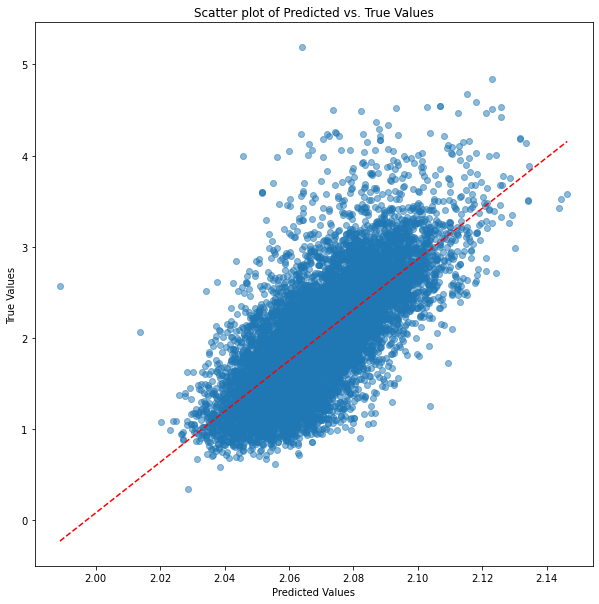

In [33]:
targets_np = np.array(targets).flatten()
predicted_np = np.array(predicted).flatten()

plt.figure(figsize=(10, 10))
plt.scatter(predicted_np, targets_np, alpha=0.5)

# Fit a linear regression model
m, b = np.polyfit(predicted_np, targets_np, 1)

# Create line points based on the min and max of the predicted values
line_x = np.linspace(min(predicted_np), max(predicted_np), 100)
line_y = m * line_x + b

# Plot the best fit line
plt.plot(line_x, line_y, '--', c='r')

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter plot of Predicted vs. True Values')
plt.show()
